In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math

In [18]:
folder_path =  '/users/mmotuz/GBO_REU/GOALS/'

df1 = pd.read_csv(folder_path + 'goals_v6.csv', skiprows = None)

df2 = pd.read_csv(folder_path + 'TABmeas_v2.csv', skiprows = None)



162


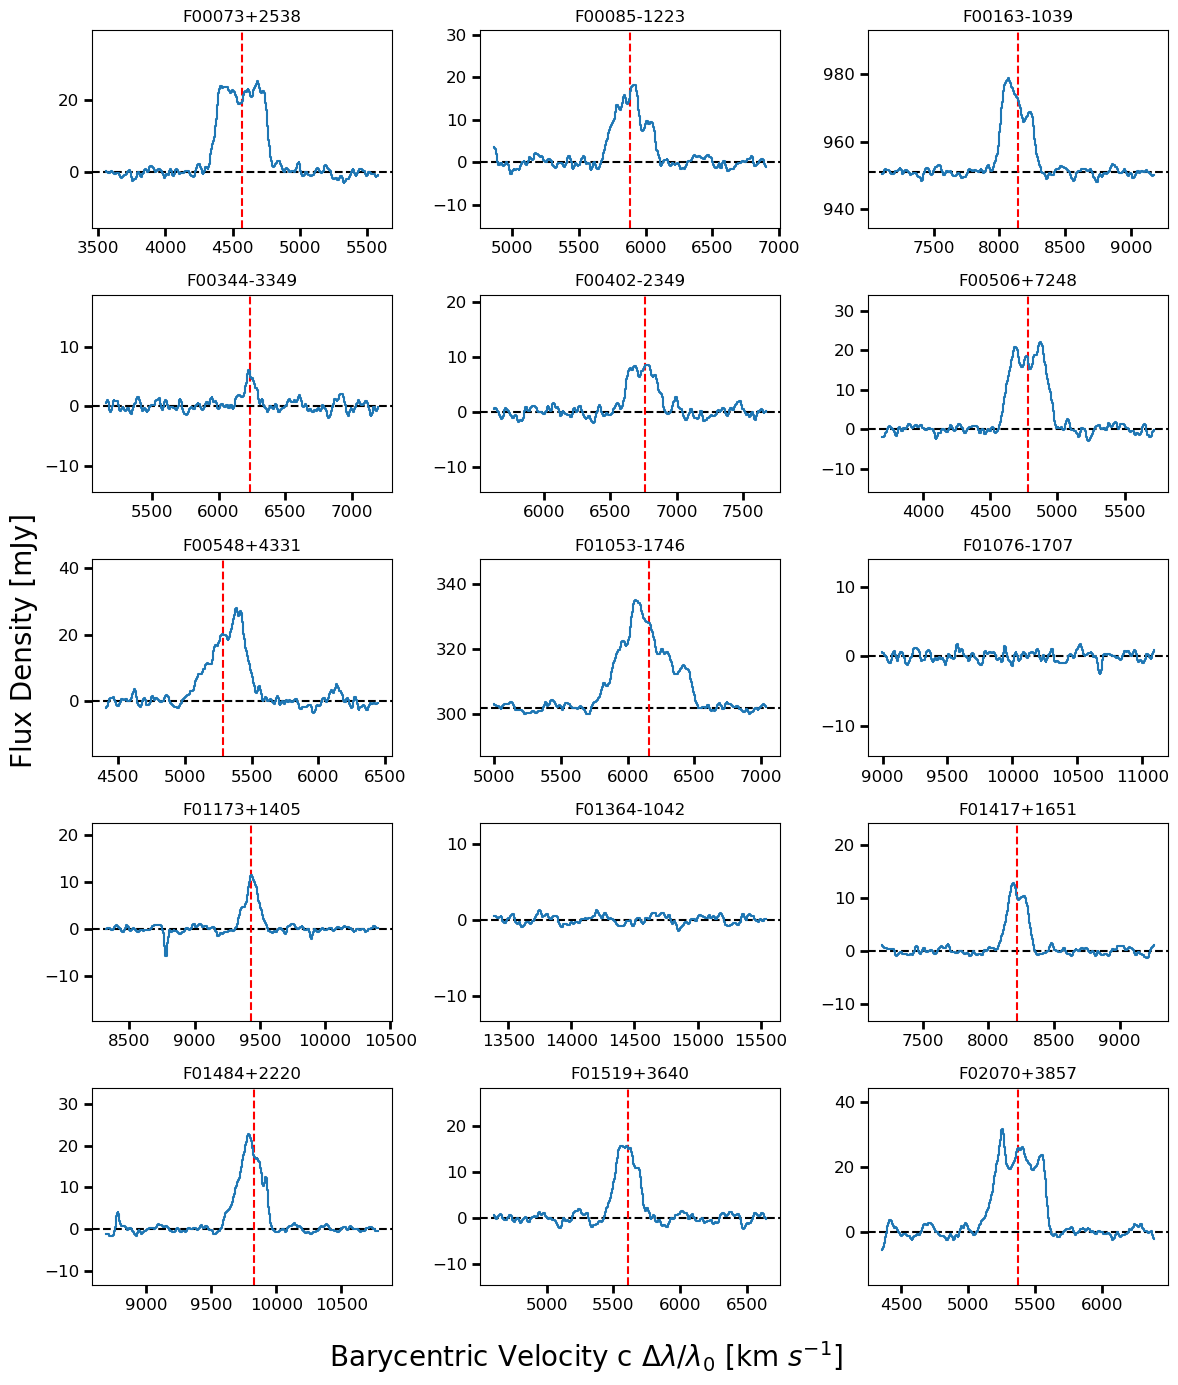

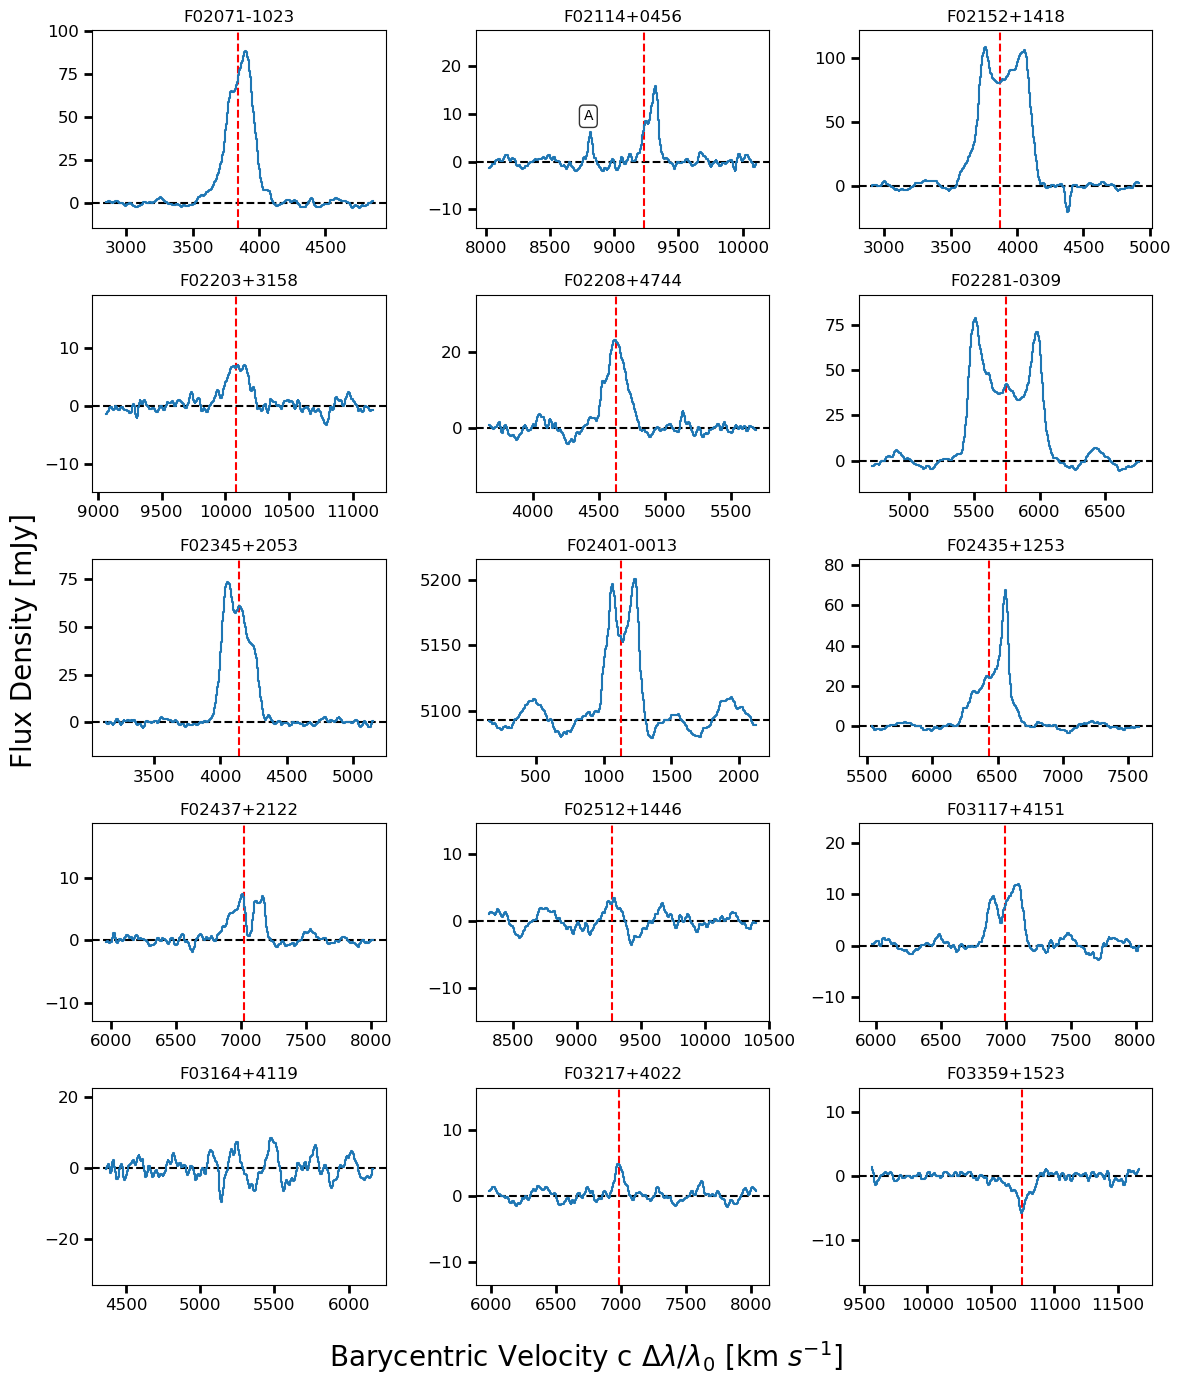

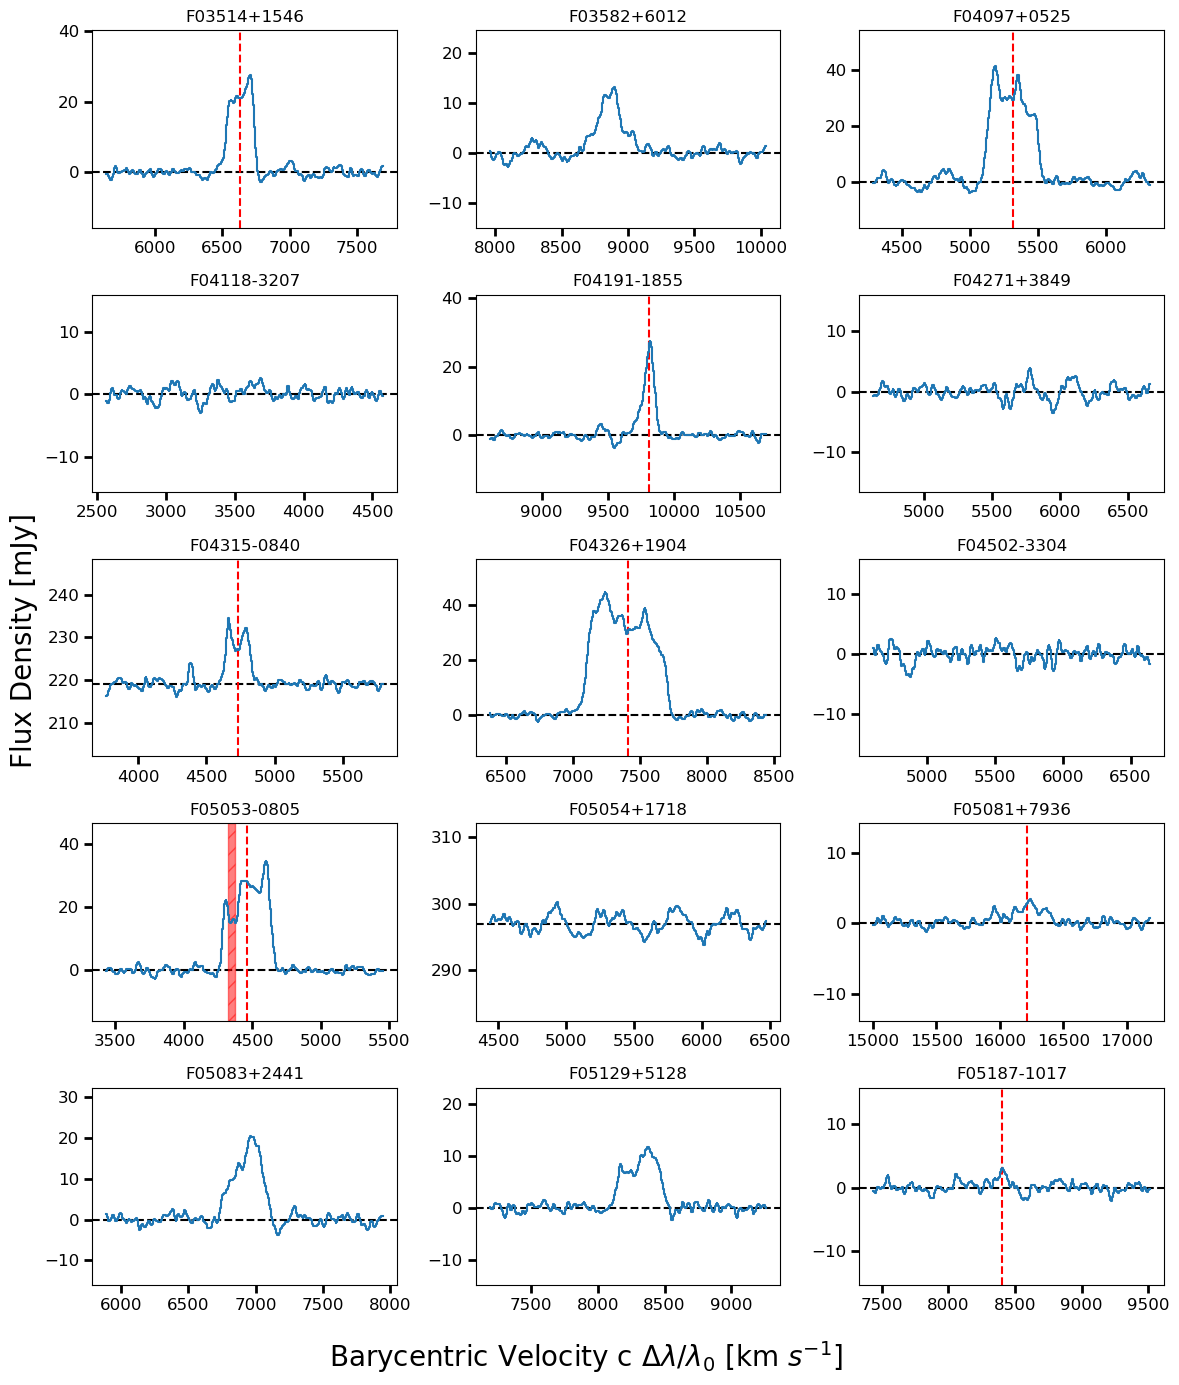

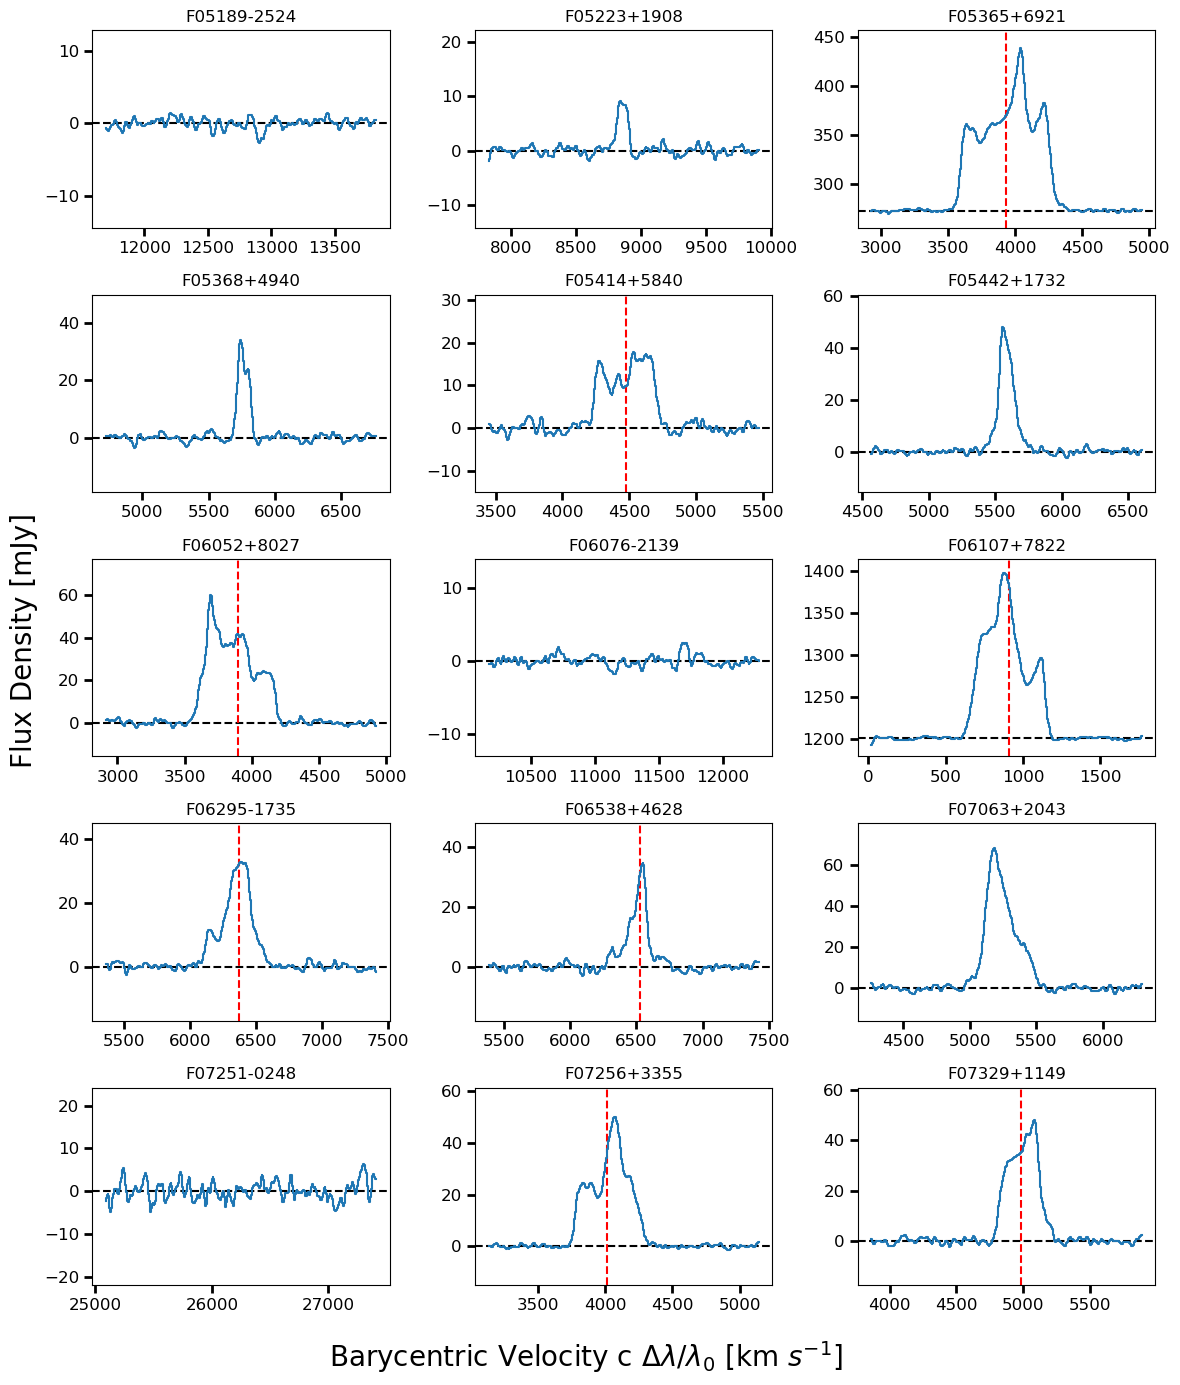

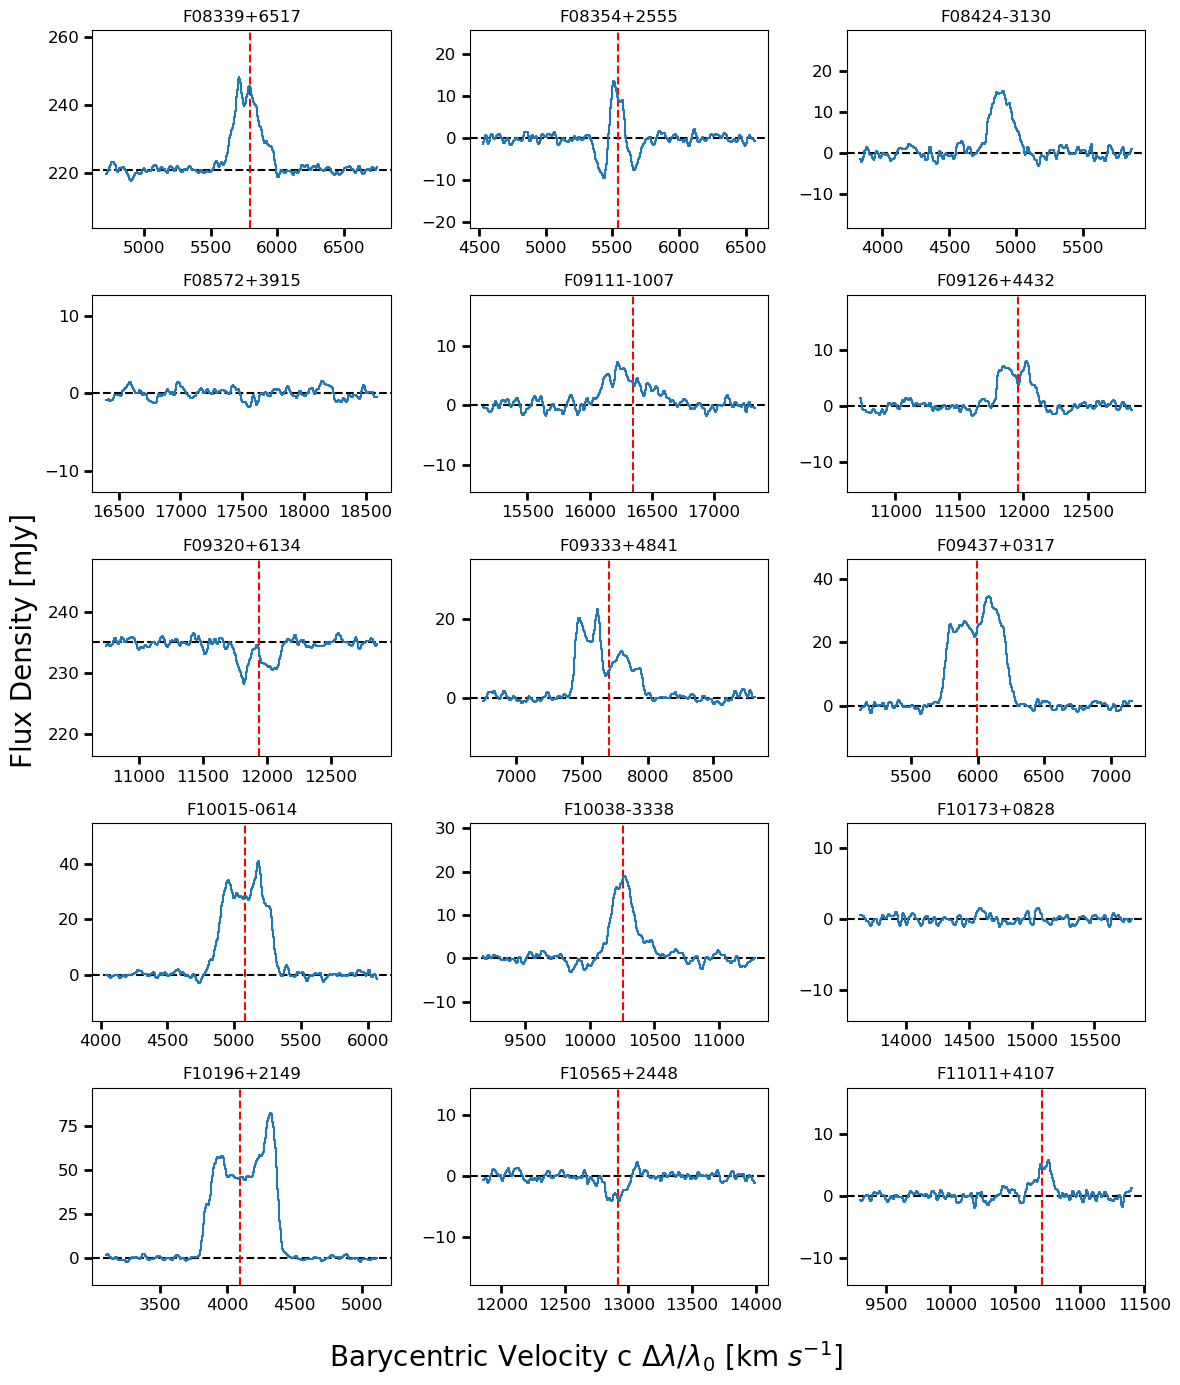

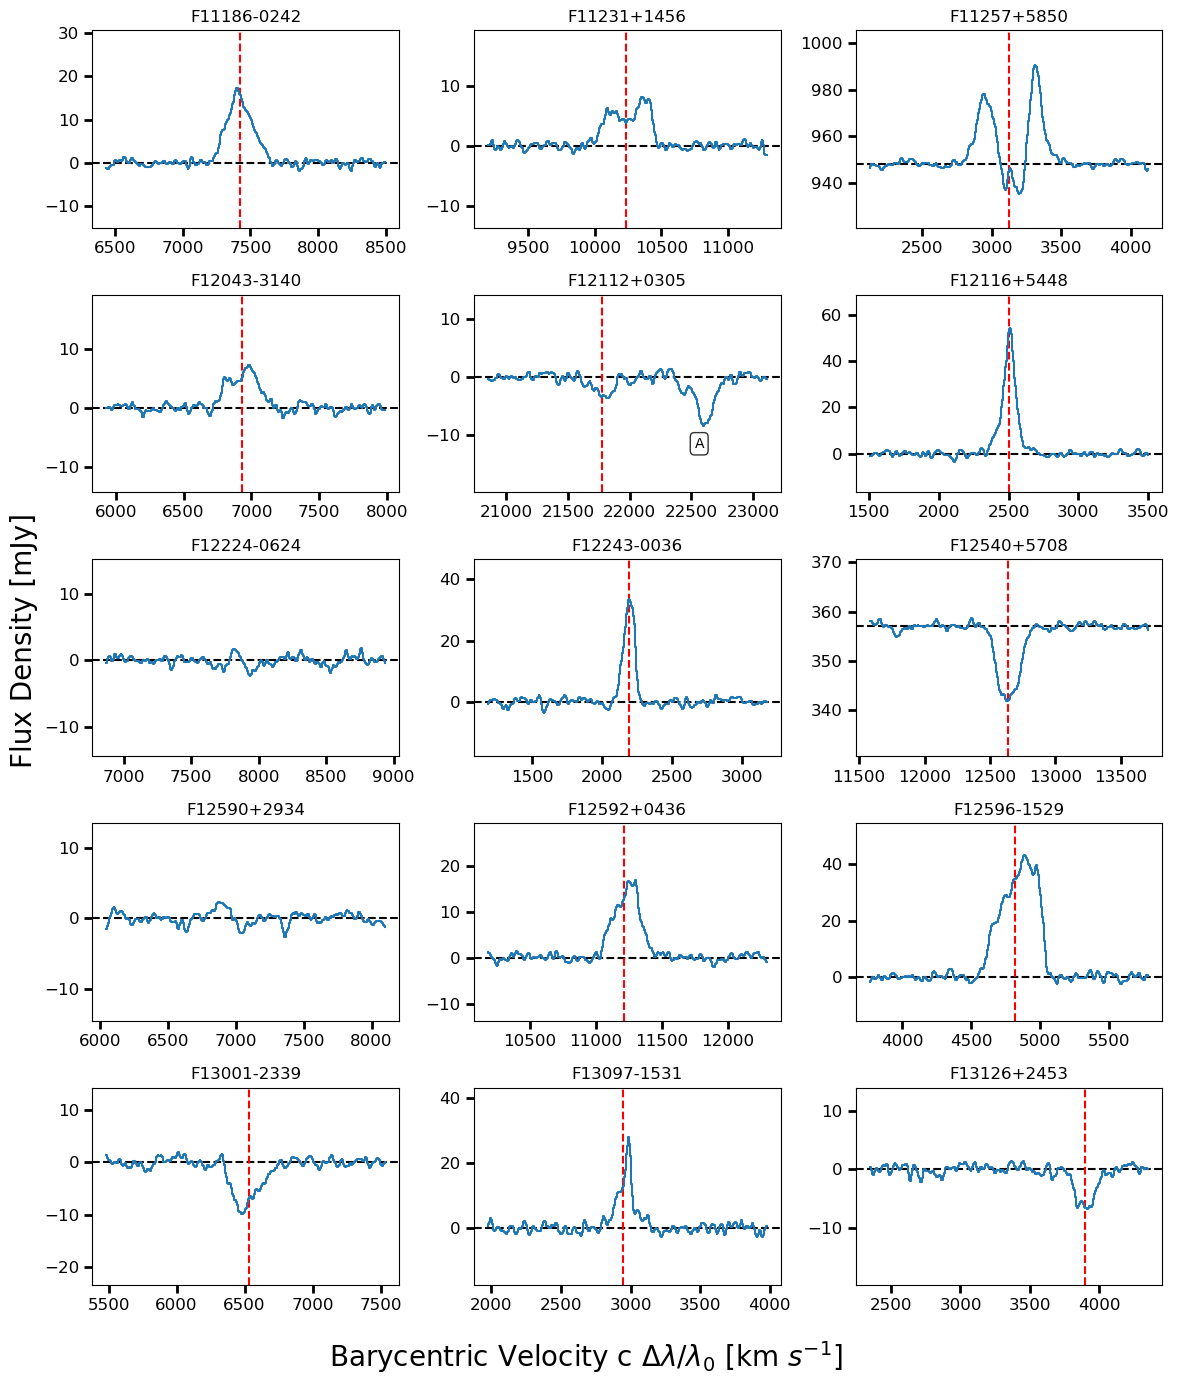

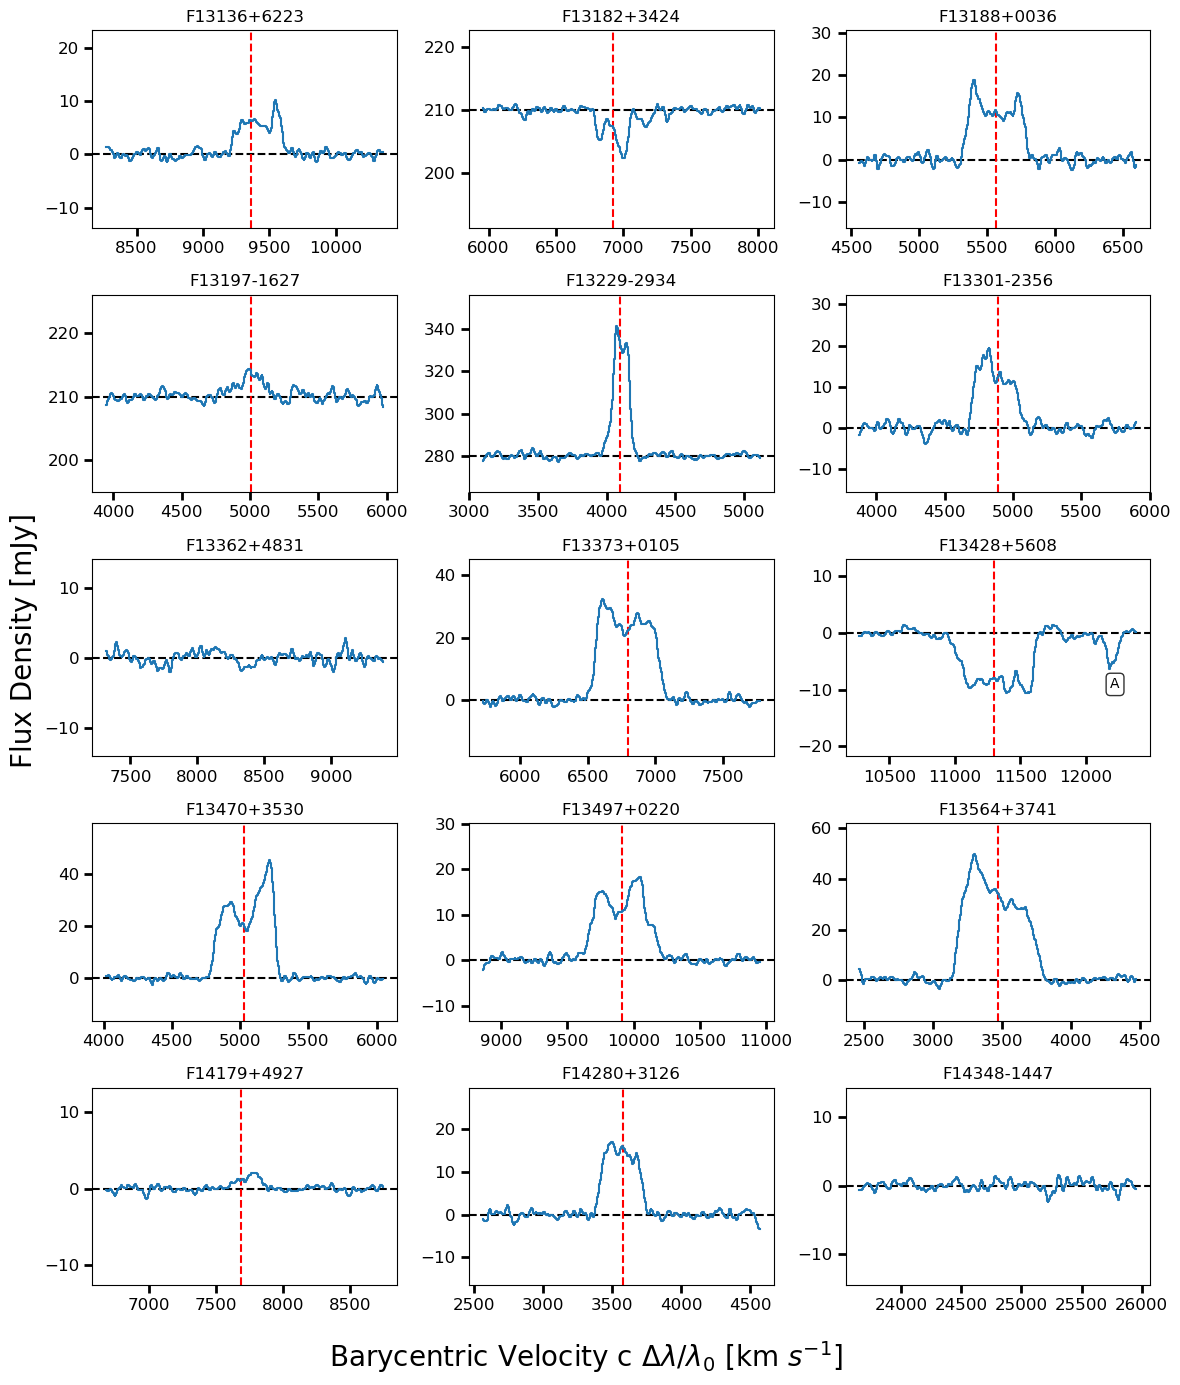

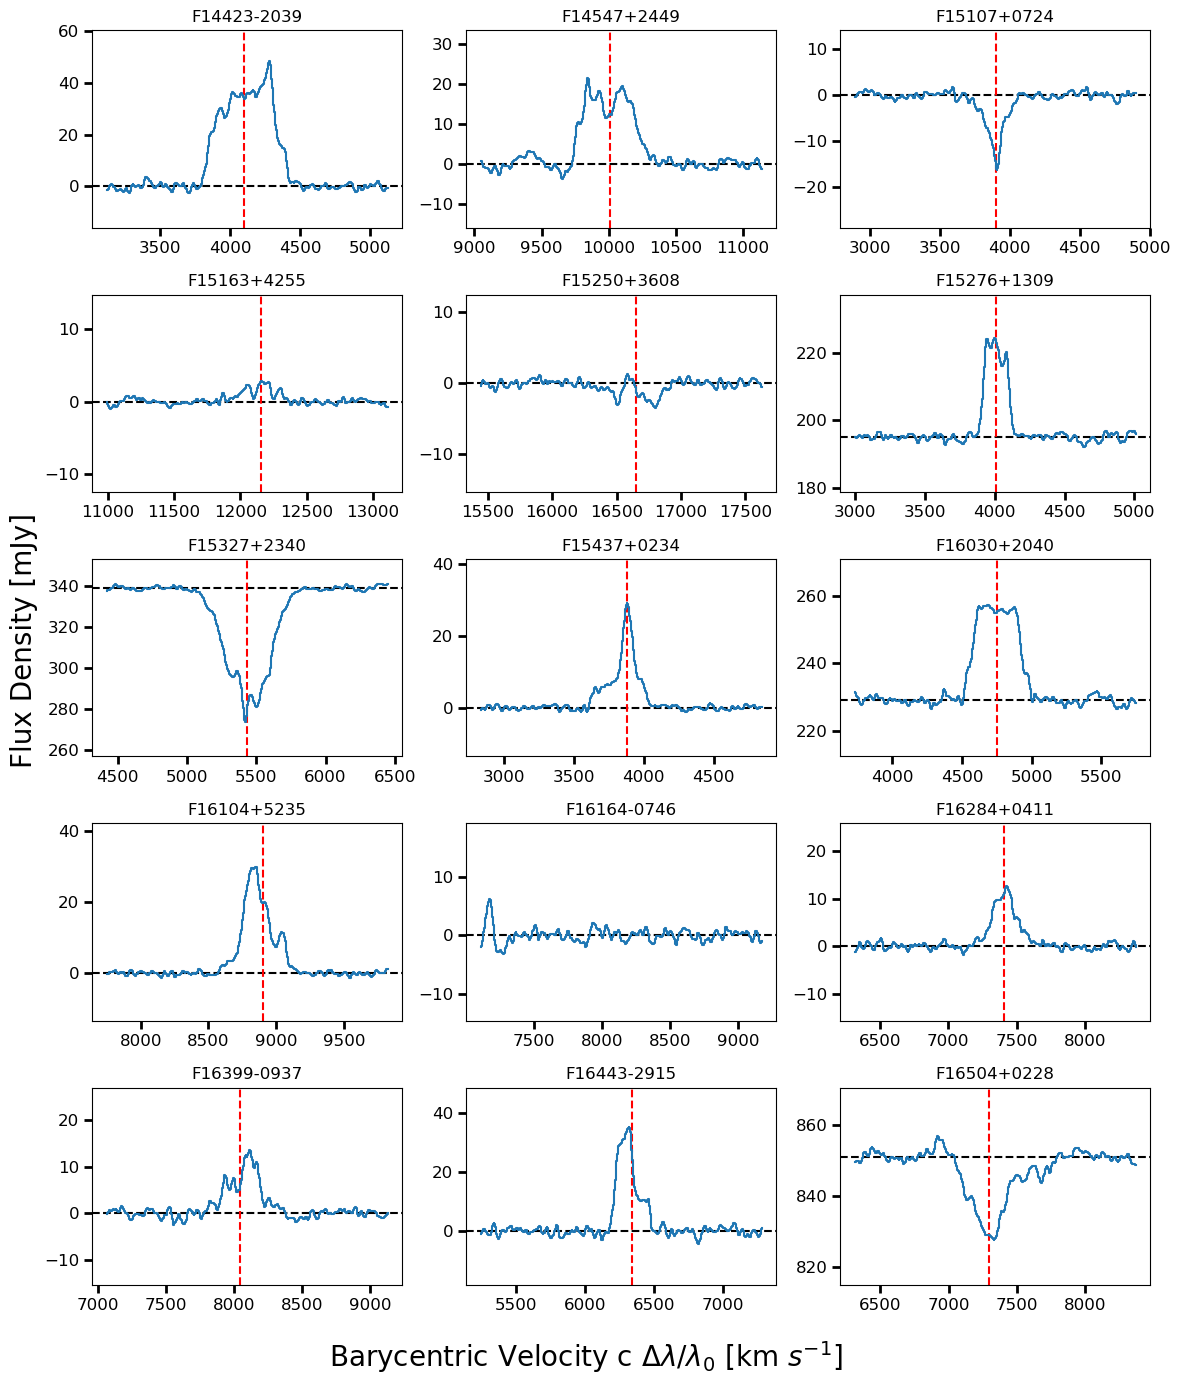

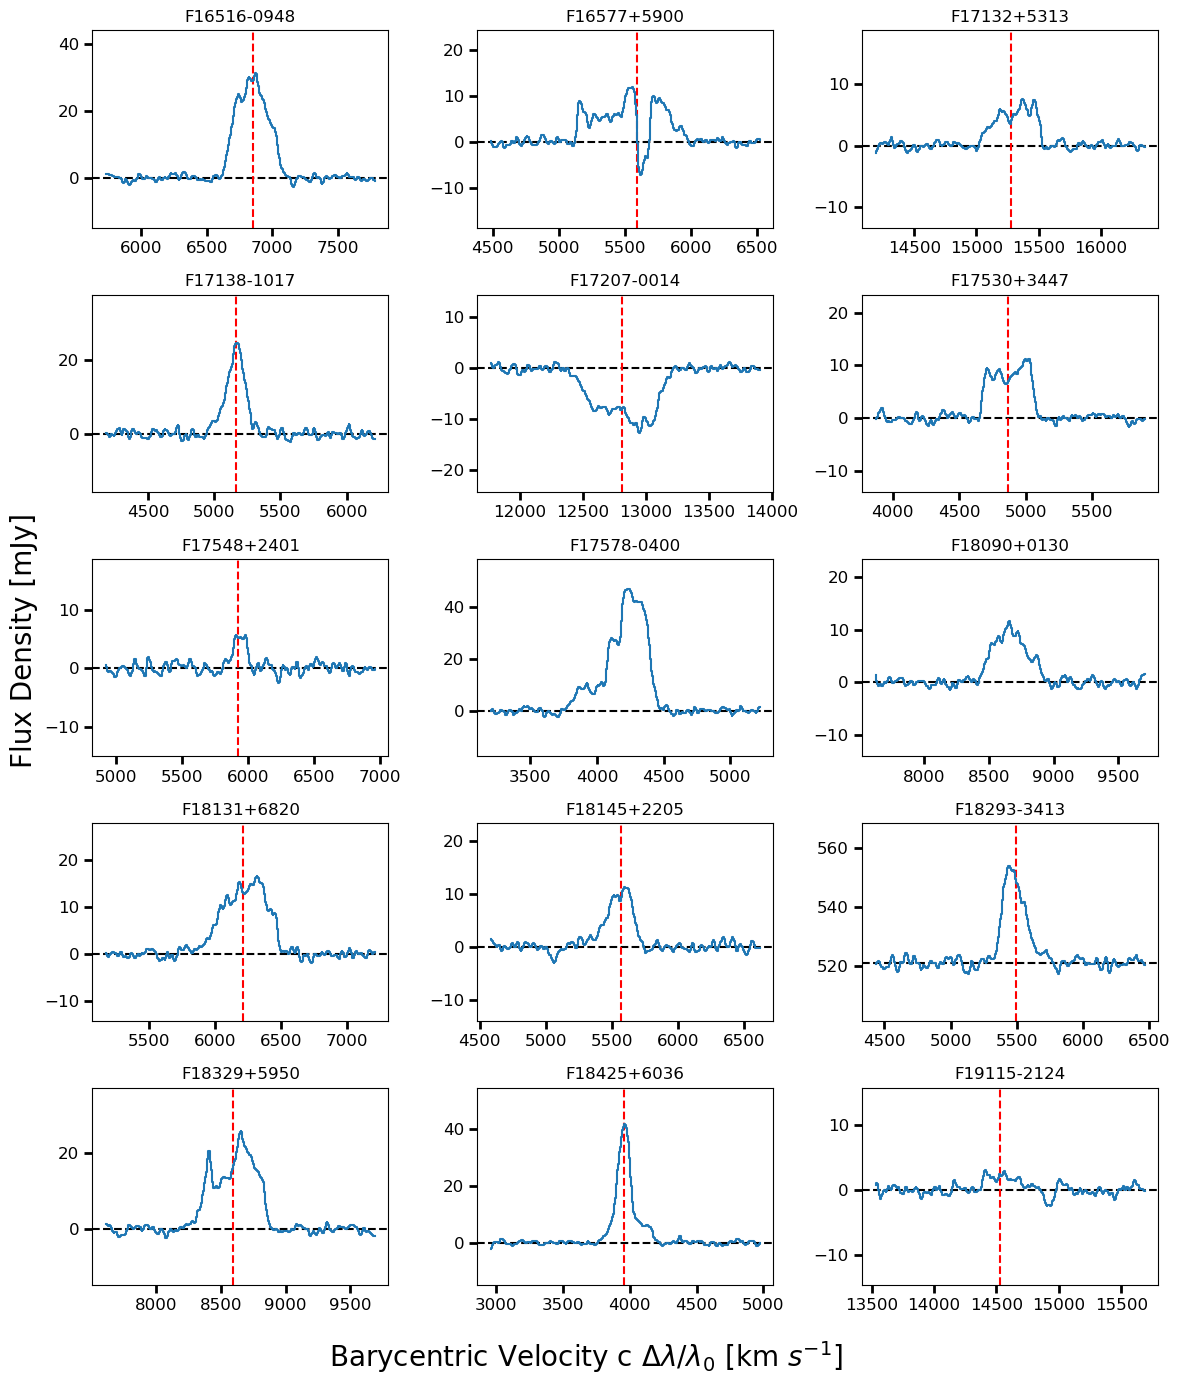

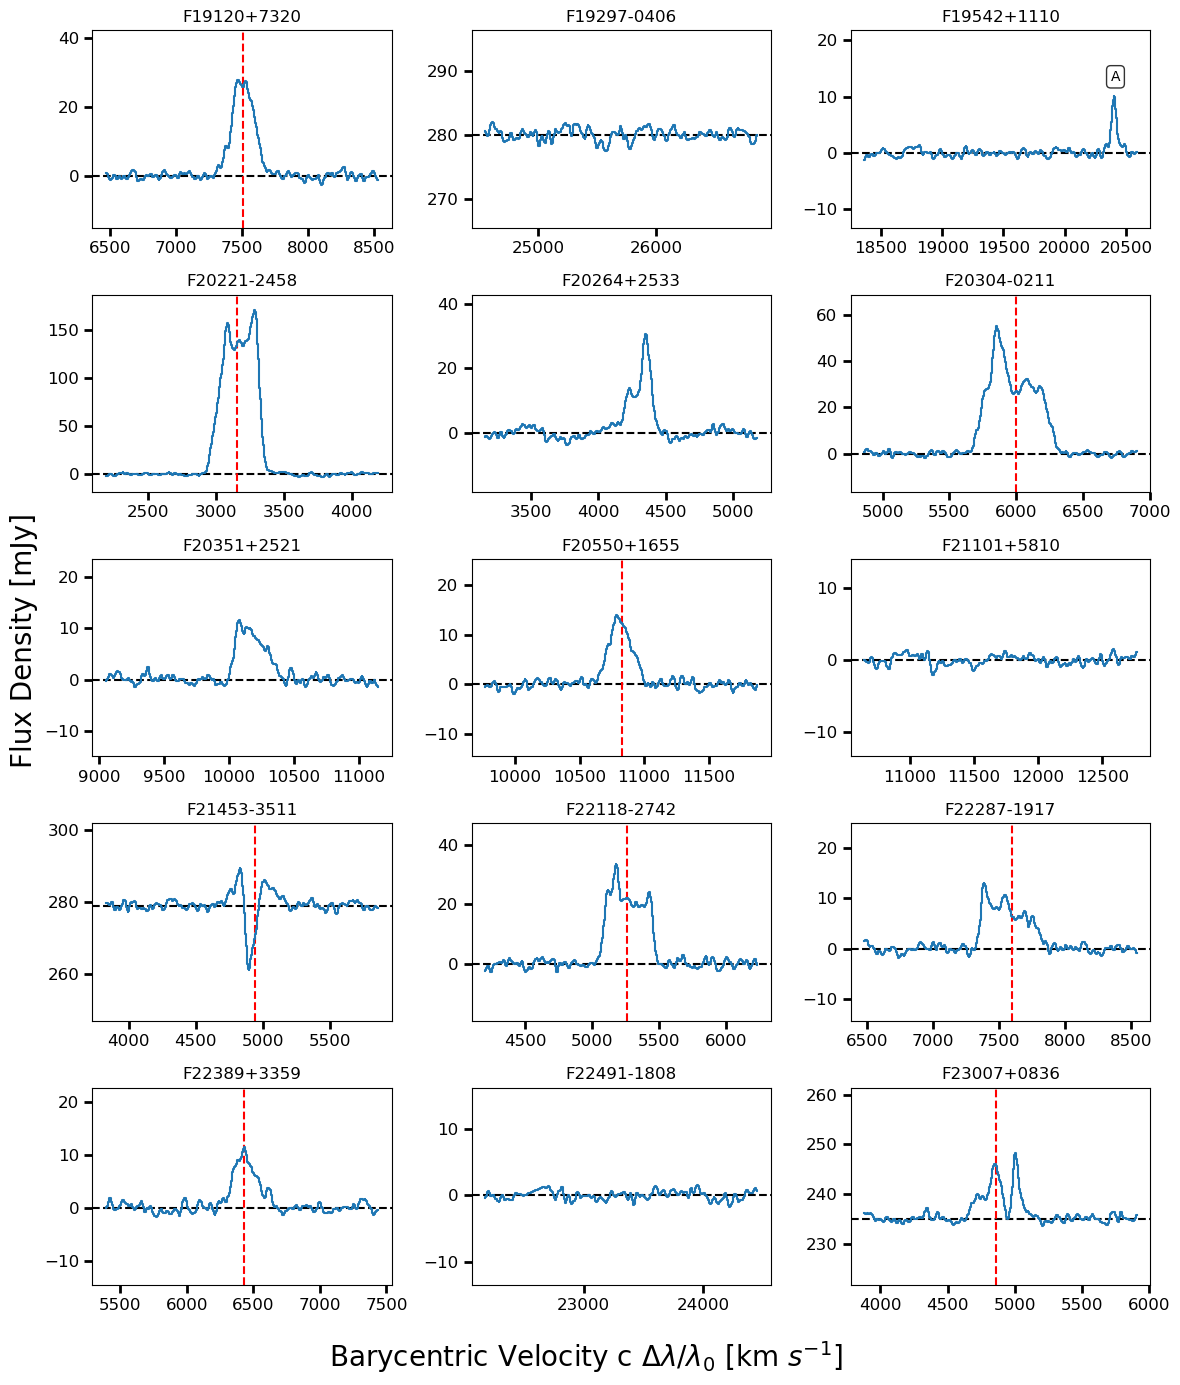

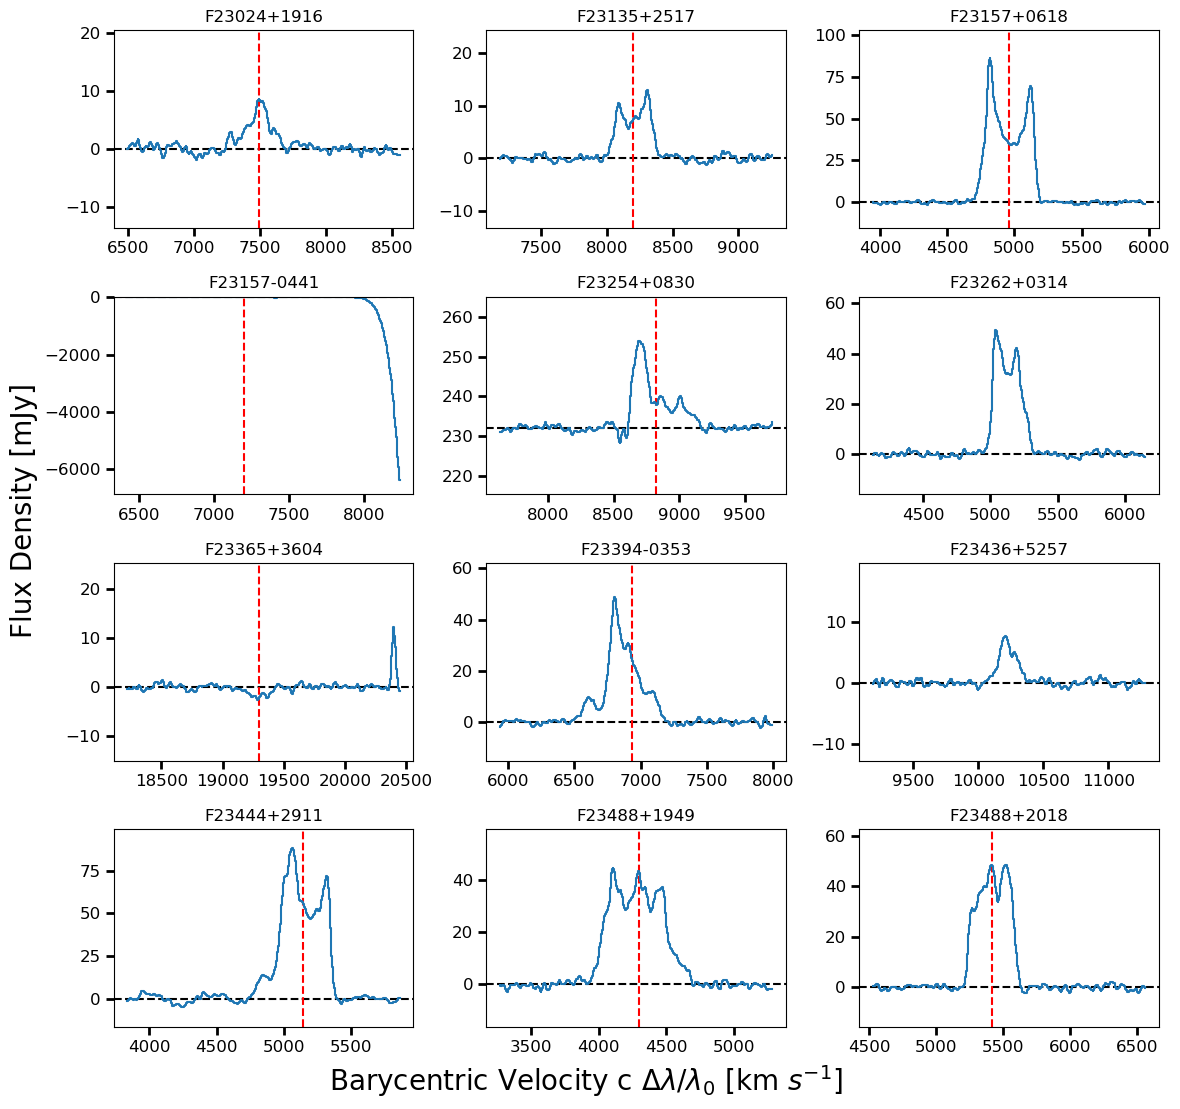

In [58]:
# Collect valid .txt files
txt_files = sorted([f for f in os.listdir(folder_path + 'DATAv3/TXT') if f.endswith('.txt')])
valid_files = []
valid_data = []
name = []
# Load and filter valid 2-column txts
for filename in txt_files:
    path = os.path.join(folder_path + 'DATAv3/TXT', filename)
    try:
        df = pd.read_csv(path, sep='\s+', skiprows=3, header=None)
        if df.shape[1] == 2:
            valid_files.append(filename)
            valid_data.append(df)
    except Exception as e:
        print(f"Skipping {filename}: {e}")

# Apply CFD correction to valid_data if CFDSign is NaN
for idx, file in enumerate(valid_files):
    # Remove '_v2.txt' to match with df2.name
    base_name = file.replace('_v2.txt', '')
    match = df2[df2['name'] == base_name]
    if not match.empty:
        cfd_sign = match['CFDSign'].values[0]
        cfd = match['CFD'].values[0]
        if base_name == 'F05053-0805':
            valid_data[idx][1] = valid_data[idx][1] - np.median(valid_data[idx][1])
        if pd.isna(cfd_sign):
            valid_data[idx][1] = valid_data[idx][1] + cfd
            


# Plot in batches of 15 (3 columns × 5 rows)
batch_size = 15
total = len(valid_files)
print(total)
num_batches = math.ceil(total / batch_size)

# ...existing code...
for b in range(num_batches):
    start = b * batch_size
    end = min(start + batch_size, total)
    batch_files = valid_files[start:end]
    batch_data = valid_data[start:end]

    n = len(batch_files)
    cols = 3
    rows = 5  # fixed 3x5 grid
    if b == num_batches - 1:
        rows = 4

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for i in range(n):
        # Use exact matching for the galaxy name
        base_name = batch_files[i].replace('_v2.txt', '').strip()
        df1_names = df1.name.astype(str).str.strip()
        if base_name in df1_names.values:
            matched_name = base_name
        else:
            matched_name = base_name  # fallback, but at least it's consistent

        if any(x in batch_files[i] for x in ['F03164+4119', 'F23157-0441', 'F06107+7822']):
            begin = 100
            stop = -100
        else:
            begin = 75
            stop = -75

        # Ensure slicing does not go out of bounds
        data_len = len(batch_data[i][0])
        start_idx = begin if begin >= 0 else max(data_len + begin, 0)
        stop_idx = stop if stop >= 0 else max(data_len + stop, 0)
        if stop_idx <= start_idx:
            stop_idx = data_len

        ax = axes[i]
        ax.plot(batch_data[i][0][start_idx:stop_idx], gaussian_filter1d(batch_data[i][1][start_idx:stop_idx], 2) * 1000, drawstyle='steps-mid', zorder=2)
        if np.median(gaussian_filter1d(batch_data[i][1][start_idx:stop_idx], 2) * 1000) < 20:
            ax.axhline(y=0, color='black', linestyle='--', zorder=1)
        else:
            cfd_value = df2[df2['name'] == matched_name]['CFD'].values
            if len(cfd_value) > 0:
                ax.axhline(y=cfd_value[0] * 1000, color='black', linestyle='--', zorder=1)
            else:
                ax.axhline(y=0, color='black', linestyle='--', zorder=1)
        ax.set_ylim(np.min(batch_data[i][1][start_idx:stop_idx] * 1000) - 10, np.max(batch_data[i][1][start_idx:stop_idx] * 1000) + 10)
        if batch_files[i] == 'F05053-0805_v2.txt':
            ax.axvspan(4325, 4375, color='r', hatch='//', alpha=0.5, zorder=1)
        if batch_files[i] == 'F12112+0305_v2.txt':
            ax.text(0.75, 0.28, 'A', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if batch_files[i] == 'F13428+5608_v2.txt':
            ax.text(0.9, 0.4, 'A', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.set_title(matched_name)
        if batch_files[i] == 'F19542+1110_v2.txt':
            ax.text(0.9, 0.8, 'A', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if batch_files[i] == 'F02114+0456_v2.txt':
            ax.text(0.4, 0.6, 'A', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.tick_params(axis='both', which='both', length=6, width=2, labelsize=12)
        # Draw vertical line at HI velocity if available and line[Jykm/s] != 0
        line_val = df1.loc[df1['name'] == matched_name, 'line[Jykm/s]']
        hi_vel_val = df2.loc[df2['name'] == matched_name, 'HI_Vel']
        if not line_val.empty and line_val.values[0] != 0 and not hi_vel_val.empty:
            ax.axvline(x=hi_vel_val.values[0], color='red', linestyle='--', zorder=1, label='HI Velocity')

    # Hide unused subplots in the final (partial) batch
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    # Shared labels and title
    fig.supxlabel(r'Barycentric Velocity c $\Delta\lambda / \lambda_0$ [km $s^{-1}$]', fontsize=20)
    fig.supylabel('Flux Density [mJy]', fontsize=20)

    # Layout adjustments
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])   # Leaves space for suptitle and xlabel

    fig.subplots_adjust(bottom=0.07)             # Pushes xlabel closer to subplots

    plt.show()
    plt.close(fig)  # Frees memory, prevents layout bleed across figures

In [5]:
def plotWithFit(X, y, xlabel, ylabel):
    X_ = sm.add_constant(X)
    # Fit LAD regression (Quantile Regression at q=0.5)
    mod = sm.QuantReg(y, X_)
    res = mod.fit(q=0.5)
    # Predict over a smooth range for plotting
    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_ = sm.add_constant(X_pred)
    y_pred = res.predict(X_pred_)
    slope = res.params[1]
    intercept = res.params[0]
    plt.figure()
    plt.loglog(np.power(10,X), np.power(10, y), 'o', markersize=5, alpha=0.5)
    plt.plot(np.power(10, X_pred), np.power(10, y_pred), color='red', linewidth=2,
         label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.show()

    return slope, intercept

def plotWithFitErr(X, y, yerr, bin, xlabel, ylabel):


    idx = np.argsort(X)
    X = X.iloc[idx]
    y = y.iloc[idx]
    yerr = yerr.iloc[idx]
    yerr = yerr/2.3


    # Fit LAD (Quantile Regression at q=0.5)
    X_ = sm.add_constant(X)
    mod = sm.QuantReg(y, X_)
    res = mod.fit(q=0.5)

    # Smooth prediction line
    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_ = sm.add_constant(X_pred)
    y_pred = res.predict(X_pred_)
    slope, intercept = res.params[1], res.params[0]

    X_bin = []
    newy = []
    MAD = []
    x_min = X.min()
    x_max = X.max()
    bins = np.arange(x_min, x_max + bin, bin)
    for i in range(len(bins) - 1):
        mask = (X >= bins[i]) & (X < bins[i+1])
        if np.any(mask):
            X_bin.append(X[mask].mean())
            newy.append(np.median(y[mask]))
            MAD.append(np.median(np.abs(y[mask] - np.median(y[mask]))))
    X_bin = np.array(X_bin)
    Mad = np.array(MAD)

    sigmaMAD = Mad * 1.48  # Convert MAD to standard deviation

    upper = newy + sigmaMAD
    lower = newy - sigmaMAD

    steepslope = (lower[-1] - upper[0]) / (X_bin[-1] - X_bin[0])

    lessslope = (upper[-1] - lower[0]) / (X_bin[-1] - X_bin[0])

    print(steepslope)
    print(lessslope)
    # Plotting
    plt.figure()
    plt.errorbar(X, y, yerr=yerr, fmt='o',
                 markersize=5, alpha=0.5, label='M/L Error')
    plt.plot(X_pred, y_pred, color='red', linewidth=0.5,
             label=f'LAD fit: slope = ${slope:.4f}$, intercept = ${intercept:.3f}$')
    plt.fill_between(X_bin,
                     upper,
                     lower,
                     color='red', alpha=0.3, label='MAD Error')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.show()

    return slope, intercept


def sanityCheck(X, y, n, observed, label):
    slopes = []
    X_log = np.log10(X)
    for _ in range(n):
        shuffled_y = np.random.permutation(y)
        y_perm = np.log10(shuffled_y / X)
        X_ = sm.add_constant(X_log)
        mod = sm.QuantReg(y_perm, X_)
        res = mod.fit(q=0.5)
        slopes.append(res.params[1])
    plt.figure()
    plt.hist(slopes, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=observed, color='red', linestyle='--', label=f'Observed Slope = {observed:.4f}')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [6]:
logLir = df1['log(Lir)']
Lir = np.power(10, logLir) # Convert log Lir to Lir
dist = df1['Dlum[Mpc]']  # Use 'Dlum[Mpc]' for distance in Mpc
SHI = df1['line[Jykm/s]']
velocity = df1['50centerVel']

c = 299792.458 #km/s
z = velocity / c  # Convert velocity to redshift

percent_error = 0.1
M_h1 = (2.36e5/(1+z)**2) * SHI * dist**2

deltaV20 = df1.w20
Mdyn = 40 * deltaV20**4


In [7]:
exclude_codes = ['0', '3', '4', '5']
mask = (~df1.fit.astype(str).str.contains('|'.join(exclude_codes), na=False)) & (df1.w20 >= 0.0)

/tmp/ipykernel_529763/1376563260.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_529763/1376563260.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_529763/1376563260.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


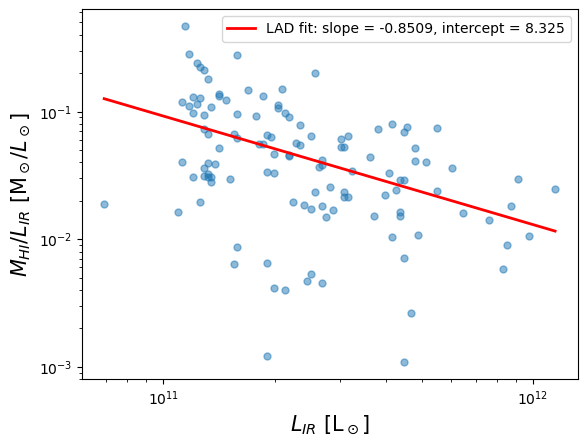

/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


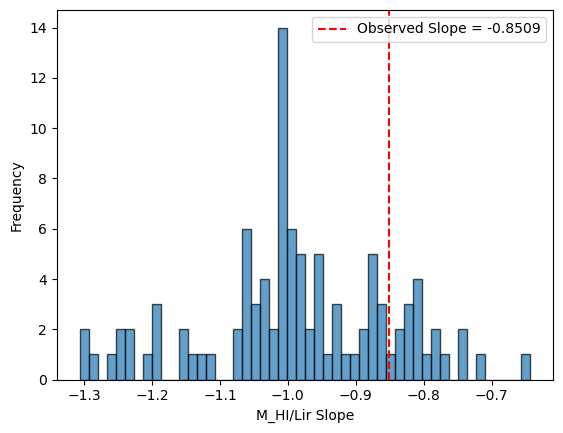

-0.8508618569993384


In [8]:
MhLVLSlope, MhLVLIntercept = plotWithFit(logLir[mask], np.log10(M_h1[mask]/Lir[mask]),
                                       r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

sanityCheck(np.power(10, logLir)[mask].values, M_h1[mask].values, 100, MhLVLSlope, 'M_HI/Lir Slope')

print(MhLVLSlope)

/tmp/ipykernel_529763/1376563260.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_529763/1376563260.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_529763/1376563260.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


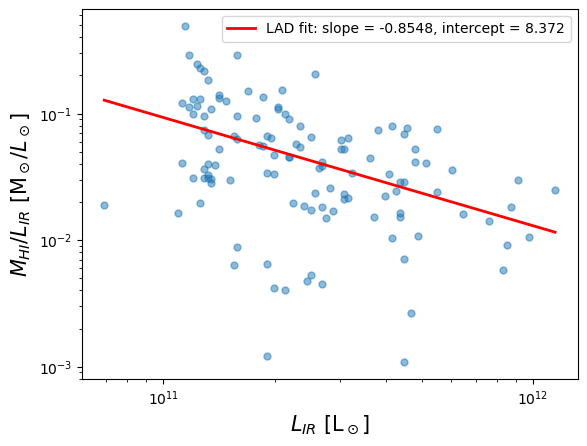

In [9]:
mhlSlopeErr, mhlInterceptErr = plotWithFit(logLir[mask], np.log10(M_h1[mask]/Lir[mask]) + (M_h1[mask]/Lir[mask]) * percent_error/2.3,
                                       r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

-1.2300189385872375
0.4504331107089148


/tmp/ipykernel_529763/1376563260.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


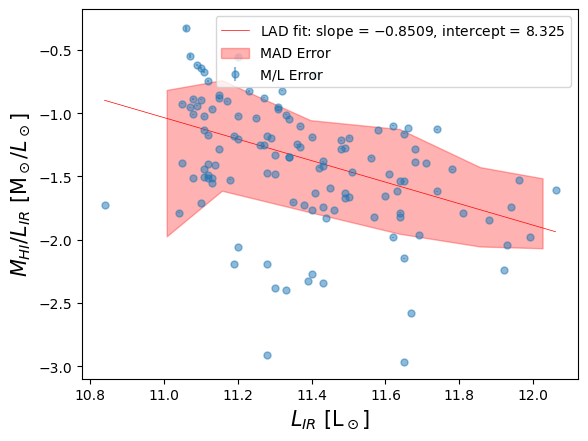

(-0.850861856987233, 8.324552803712699)

In [10]:
plotWithFitErr(logLir[mask], np.log10(M_h1[mask]/Lir[mask]), 
               (M_h1[mask]/Lir[mask] * percent_error), .225,
               r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

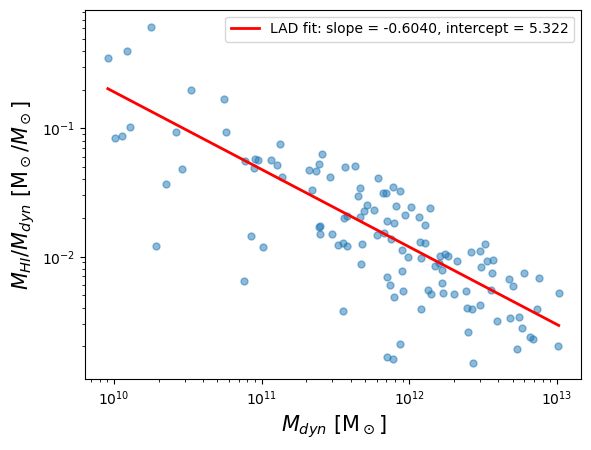

/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


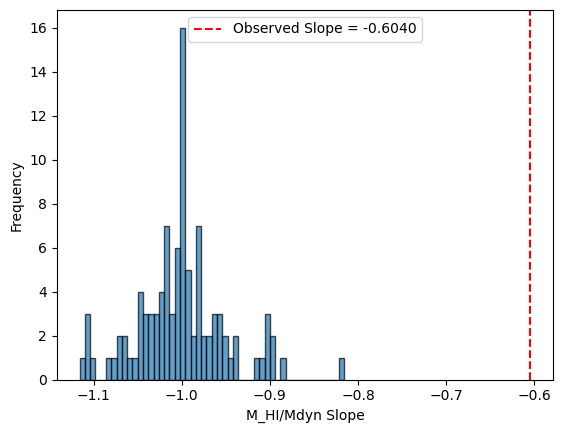

In [11]:
MhMdVMdSlope, MhMdVMdIntercept = plotWithFit(
    np.log10(Mdyn[mask].values), 
    np.log10((M_h1[mask] / Mdyn[mask]).values),
    r'$M_{dyn}$ [M$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]'
)

sanityCheck(Mdyn[mask].values, M_h1[mask].values, 100, MhMdVMdSlope, 'M_HI/Mdyn Slope')

-0.8308299122036187
-0.19592400033277457


/tmp/ipykernel_529763/1376563260.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


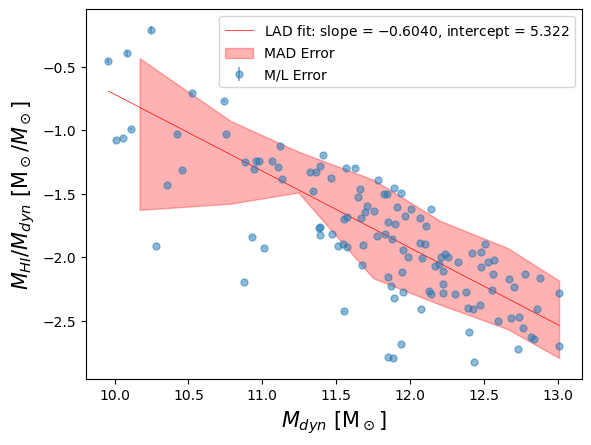

(-0.6039880697265396, 5.322240257774248)

In [12]:
plotWithFitErr(np.log10(Mdyn[mask]), np.log10(M_h1[mask]/Mdyn[mask]), 
               (M_h1[mask]/Mdyn[mask] * percent_error), .5,
               r'$M_{dyn}$ [M$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]')

/tmp/ipykernel_529763/1376563260.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_529763/1376563260.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_529763/1376563260.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


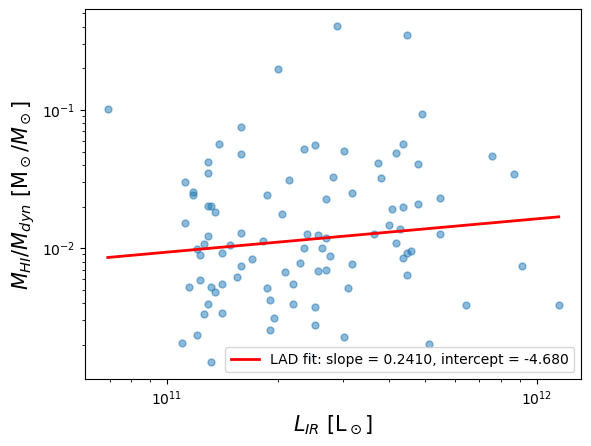

In [13]:
NGEMMask = df1.fit.astype(str).str.contains('1', na=False) & (df1.w20 >= 0.0)

niceSlope, niceIntercept = plotWithFit(
    logLir[NGEMMask], 
    np.log10(M_h1[NGEMMask] / Mdyn[NGEMMask]),
    r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]')

94 points for EM-NG
26 points for EM-G
6 points for EM+ABS
Total number of points plotted: 126


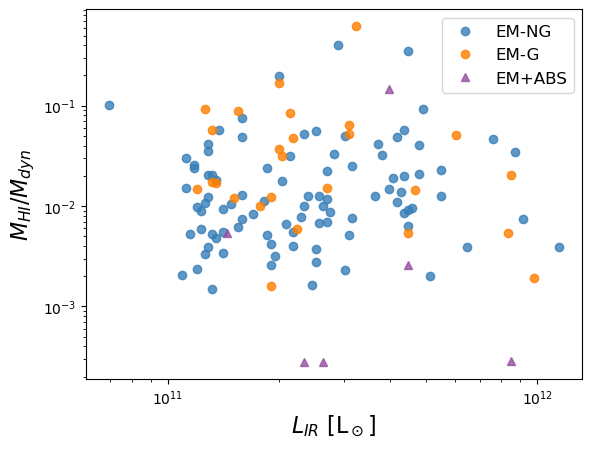

In [14]:
def MhMdVLPlot(df1):

    count = 0
    exclude_codes = ['0', '3', '4']
    mask = ~df1.fit.astype(str).str.contains('|'.join(exclude_codes), na=False) & (df1.w20 >= 0.0)

    newDF = df1[mask].reset_index(drop=True)
    Lir = np.power(10, newDF['log(Lir)'])
    dist = newDF['Dlum[Mpc]']  # Use 'Dlum[Mpc]' for distance in Mpc
    SHI = newDF['line[Jykm/s]']

    c = 299792.458  # km/s
    velocity = newDF['50centerVel']
    z = velocity / c  # Convert velocity to redshift

    M_h1 = (2.36e5/(1+z)**2) * SHI * dist**2
    deltaV20 = newDF.w20
    Mdyn = 40 * deltaV20**4

    filtered_code_info = [
    ('1', '#377eb8', 'EM-NG', 'o'),
    ('2', '#ff7f00', 'EM-G', 'o'),
    ('5', '#984ea3', 'EM+ABS', '^'),
    ]    

    for code_val, color, label, marker in filtered_code_info:
        idx = newDF.fit.astype(str).str.contains(code_val, na=False)
        n_points = idx.sum()
        count += n_points
        if n_points > 0:
            plt.loglog(Lir[idx], (M_h1 / Mdyn)[idx], marker, markersize=6, color=color, alpha=0.8, label=label)
            print(f"{n_points} points for {label}")

    plt.xlabel(r'$L_{IR}$ [L$_\odot$]', fontsize=16)
    plt.ylabel(r'$M_{H I}/M_{dyn}$', fontsize=16)
    plt.legend(fontsize=12)
    print(f"Total number of points plotted: {count}")
    plt.show()

MhMdVLPlot(df1)



Galaxy: F13126+2453
Difference: 552.1999999999998 km/s
Optical Velocity: 3346.0 km/s
Radio Velocity: 3898.2 km/s

Galaxy: F11011+4107
Difference: 384.0 km/s
Optical Velocity: 10349.0 km/s
Radio Velocity: 10733.0 km/s

Galaxy: F23444+2911
Difference: 313.6999999999998 km/s
Optical Velocity: 4845.0 km/s
Radio Velocity: 5158.7 km/s

Most Negative Difference:
Galaxy: F12112+0305
Difference: -175.79999999999927 km/s
Optical Velocity: 21978.0 km/s
Radio Velocity: 21802.2 km/s


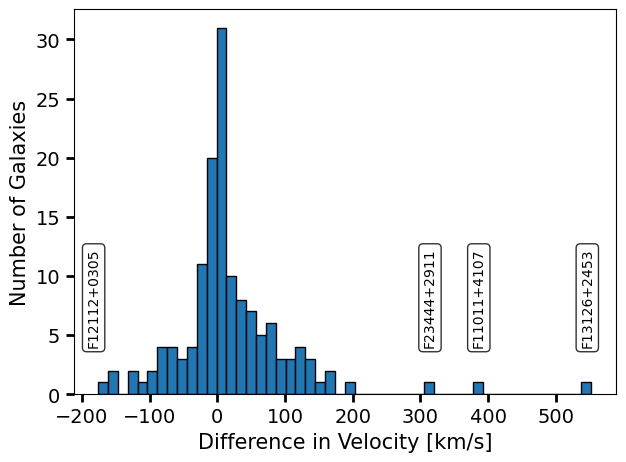

In [15]:
df2 = pd.read_csv(folder_path + 'TABmeas_v2.csv', skiprows=None)

# Filter out rows in df1 where cz == 0
mask = df1['50centerVel'] != 0
filtered_df1 = df1[mask].reset_index(drop=True)

# Get the names of the remaining galaxies
remaining_names = set(filtered_df1['name'])

# Filter df2 to keep only rows with names in remaining_names
filtered_df2 = df2[df2['name'].isin(remaining_names)].reset_index(drop=True)


czVel = np.array(filtered_df1['OptVel[km/s]'])
radVel = np.array(filtered_df1['50centerVel'])

differenceVel = radVel - czVel

# Plot histogram of velocity differences
fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.hist(differenceVel, bins=50, edgecolor='black')
ax2.set_xlabel('Difference in Velocity [km/s]', fontsize=15)
ax2.set_ylabel('Number of Galaxies', fontsize=15)
ax2.tick_params(axis='both', which='both', length=6, width=2, labelsize=14)
ax2.text(0.96, 0.38, 'F13126+2453', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(0.76, 0.38, 'F11011+4107', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(0.67, 0.38, 'F23444+2911', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(0.05, 0.38, 'F12112+0305', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
         
names = filtered_df1['name'].values

# Find and print top 3 largest positive velocity differences
for _ in range(3):
    idx = np.argmax(differenceVel)
    print(f'Galaxy: {names[idx]}')
    print(f'Difference: {differenceVel[idx]} km/s')
    print(f'Optical Velocity: {czVel[idx]} km/s')
    print(f'Radio Velocity: {radVel[idx]} km/s\n')
    
    # Remove this entry from all arrays
    differenceVel = np.delete(differenceVel, idx)
    czVel = np.delete(czVel, idx)
    radVel = np.delete(radVel, idx)
    names = np.delete(names, idx)

# Smallest (most negative) difference
idx = np.argmin(differenceVel)
print('Most Negative Difference:')
print(f'Galaxy: {names[idx]}')
print(f'Difference: {differenceVel[idx]} km/s')
print(f'Optical Velocity: {czVel[idx]} km/s')
print(f'Radio Velocity: {radVel[idx]} km/s')

Code '0': 20 matches
Lir for code '0': [4.46683592e+11 7.07945784e+11 1.17489755e+11 1.28824955e+11
 1.47910839e+11 1.65958691e+11 1.44543977e+12 4.46683592e+11
 2.45470892e+12 1.44543977e+12 7.24435960e+11 2.29086765e+11
 2.39883292e+11 3.63078055e+11 2.45470892e+12 4.16869383e+11
 2.81838293e+12 1.31825674e+12 6.45654229e+11 1.58489319e+12]
M_h1 for code '0': [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Code '5': 6 matches
Lir for code '5': [1.44543977e+11 3.98107171e+11 8.51138038e+11 2.34422882e+11
 2.63026799e+11 4.46683592e+11]
M_h1 for code '5': [3.49636313e+09 1.78614161e+09 1.12895421e+09 7.98952125e+09
 4.22516272e+08 2.80569071e+09]


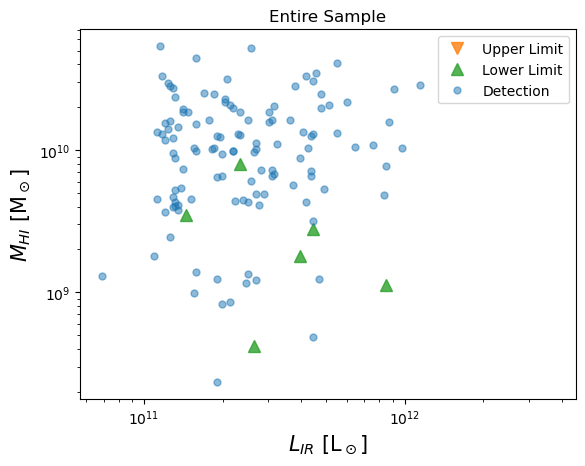

In [16]:
plt.ylabel(r'$M_{H I}$ [M$_\odot$]', fontsize=15)
plt.xlabel(r'$L_{IR}$ [L$_\odot$]', fontsize=15)



# Plot triangles for special codes
# Debug: Print how many entries match each code
for code_val, marker, color, label in [('0', 'v', 'C1', "Upper Limit"), ('5', '^', 'C2', "Lower Limit")]:
    idx = df1.fit.astype(str).str.contains(code_val, na=False)
    print(f"Code '{code_val}': {idx.sum()} matches")
    if idx.any():
        print(f"Lir for code '{code_val}':", Lir[idx].values)
        print(f"M_h1 for code '{code_val}':", M_h1[idx].values)
        plt.loglog(Lir[idx], M_h1[idx], marker, markersize=8, color=color, alpha=0.8, label=label)

# Plot circles for all other points
other_idx = ~df1.fit.astype(str).str.contains('0|5', na=False)
if other_idx.any():
    plt.loglog(Lir[other_idx], M_h1[other_idx], 'o', markersize=5, alpha=0.5, label="Detection")

plt.legend()
plt.title('Entire Sample')
plt.show()